# spaCy experiments

## Imports & initialization

Import the required modules.

In [13]:
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import spacy

Create a language model, English in this case.

In [2]:
en_nlp = spacy.load('en_core_web_sm')

## Part of speech tagging (POS)

Read a text file into a string variable.

In [3]:
with open('Data/frost.txt') as file:
    text = ''.join(file.readlines())

Parse the text using the language model.

In [4]:
doc = en_nlp(text)

Show the part of speech tags, as well as the context of the words.

In [5]:
for word in doc:
    print(f'{word.text!r}: {word.pos_}, '
          f'{word.left_edge.text!r} <- {word.head.text!r} -> {word.right_edge.text!r}')

'Two': NUM, 'Two' <- 'roads' -> 'Two'
'roads': NOUN, 'Two' <- 'roads' -> '\n'
'diverged': VERB, 'diverged' <- 'roads' -> 'wood'
'in': ADP, 'in' <- 'diverged' -> 'wood'
'a': DET, 'a' <- 'wood' -> 'a'
'yellow': ADJ, 'yellow' <- 'wood' -> 'yellow'
'wood': NOUN, 'a' <- 'in' -> 'wood'
',': PUNCT, ',' <- 'roads' -> '\n'
'\n': SPACE, '\n' <- ',' -> '\n'
'And': CCONJ, 'And' <- 'sorry' -> 'And'
'sorry': INTJ, 'And' <- 'travel' -> 'sorry'
'I': PRON, 'I' <- 'travel' -> 'I'
'could': VERB, 'could' <- 'travel' -> 'could'
'not': ADV, 'not' <- 'travel' -> 'not'
'travel': VERB, 'And' <- 'travel' -> '\n'
'both': DET, 'both' <- 'travel' -> '\n'
'\n': SPACE, '\n' <- 'both' -> '\n'
'And': CCONJ, 'And' <- 'travel' -> 'And'
'be': VERB, 'be' <- 'travel' -> '\n'
'one': NUM, 'one' <- 'traveler' -> 'one'
'traveler': NOUN, 'one' <- 'be' -> 'traveler'
',': PUNCT, ',' <- 'stood' -> ','
'long': ADV, 'long' <- 'stood' -> 'long'
'I': PRON, 'I' <- 'stood' -> 'I'
'stood': VERB, ',' <- 'be' -> '\n'
'\n': SPACE, '\n' <- '

Since we can't use backslashes in f-strings, we define a constant to represent it.

In [6]:
newline = '\n'

To split a text in sentences, a statistical model is used that was obtained from the training corpus.

In [7]:
for i, sentence in enumerate(doc.sents):
    print(f'{i:3d} {sentence.text.replace(newline, " ")}')

  0 Two roads diverged in a yellow wood, 
  1 And sorry I could not travel both And be one traveler, long I stood And looked down one as far as I could 
  2 To where it bent in the undergrowth;  Then took the other, as just as fair, And having perhaps the better claim, Because it was grassy and wanted wear; Though as for that the passing there Had worn them really about the same,  And both that morning equally lay 
  3 In leaves no step had trodden black. 
  4 Oh, I kept the first for another day! 
  5 Yet knowing how way leads on to way, I doubted if I should ever come back.  
  6 I shall be telling this with a sigh Somewhere ages and ages hence: 
  7 Two roads diverged in a wood, and I— 
  8 I took the one less traveled by, And that has made all the difference.


For poetry, sentences seem somewhat hard to detect.  However, it is possible to define a language model for English and add a rule-based sentencizer to it.

In [8]:
en_nlp_alt = spacy.lang.en.English()
sentencizer = en_nlp_alt.create_pipe('sentencizer')
en_nlp_alt.add_pipe(sentencizer)
doc = en_nlp_alt(text)
for i, sentence in enumerate(doc.sents):
    print(f'{i:3d} {sentence.text.replace(newline, " ").strip()}')

  0 Two roads diverged in a yellow wood, And sorry I could not travel both And be one traveler, long I stood And looked down one as far as I could To where it bent in the undergrowth;  Then took the other, as just as fair, And having perhaps the better claim, Because it was grassy and wanted wear; Though as for that the passing there Had worn them really about the same,  And both that morning equally lay In leaves no step had trodden black.
  1 Oh, I kept the first for another day!
  2 Yet knowing how way leads on to way, I doubted if I should ever come back.
  3 I shall be telling this with a sigh Somewhere ages and ages hence: Two roads diverged in a wood, and I— I took the one less traveled by, And that has made all the difference.


## Lemmatization

By way of example, consider Plato's *Republic*.  This is a fairly long text.

In [32]:
!wc -l -w Data/republic.mb.txt

 14601 124867 Data/republic.mb.txt


In [7]:
with open('Data/republic.mb.txt') as file:
    text = ''.join(file.readlines())

The full result of the language model parsing this text would be rather large, but for our purposes, we require only tokenization, not POS or NER, hence we disable these features.

In [8]:
doc = en_nlp(text, disable=['parser', 'ner'])

We can now perform lemmatization on all words that are not stop words, and we also eliminate named entities (`-PROP-` as value for lemma) and punctuation.  On the resulting list, a word count is performed.

In [29]:
stopwords = en_nlp.Defaults.stop_words | {'\n', '\n\n', '-PRON-'}
punctuation = ',.;?!:-'
counts = collections.Counter([token.lemma_.lower() for token in doc
                              if token.lemma_ not in stopwords and token.lemma_ not in punctuation])

The top-20 words are given below.

In [31]:
counts.most_common(20)

[('good', 619),
 ('man', 605),
 ('true', 499),
 ('yes', 446),
 ('state', 416),
 ('like', 283),
 ('reply', 267),
 ('thing', 266),
 ('great', 259),
 ('nature', 241),
 ('certainly', 238),
 ('soul', 236),
 ('justice', 231),
 ('know', 223),
 ('life', 214),
 ("'", 213),
 ('think', 207),
 ('mean', 205),
 ('let', 201),
 ('shall', 195)]

In [39]:
def plot_distr(counts, nr_words):
    words = list()
    numbers = list()
    for word, number in counts.most_common(nr_words):
        words.append(word)
        numbers.append(number)
    figure, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.bar(words, numbers)
    axes.set_xticklabels(words, rotation=45)

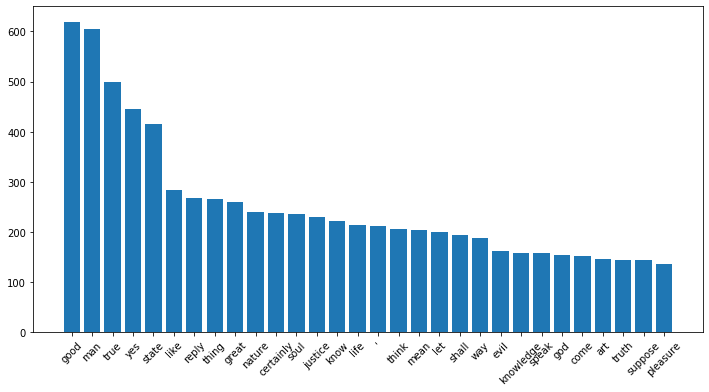

In [41]:
plot_distr(counts, 30)

## Named entiry recognition (NER)

Named entity recognition is supported as well.

In [9]:
sentence = 'Music by Johann Sebastian Bach is better than that by Friederich Buxtehude. Both lived in Germany'

In [10]:
doc = en_nlp(sentence)

In [11]:
for i, word in enumerate(doc):
    print(f'{i:3d} {word.text!r}: {word.pos_}, {word.ent_type_}')

  0 'Music': NOUN, 
  1 'by': ADP, 
  2 'Johann': PROPN, PERSON
  3 'Sebastian': PROPN, PERSON
  4 'Bach': PROPN, PERSON
  5 'is': VERB, 
  6 'better': ADJ, 
  7 'than': ADP, 
  8 'that': DET, 
  9 'by': ADP, 
 10 'Friederich': PROPN, PERSON
 11 'Buxtehude': PROPN, PERSON
 12 '.': PUNCT, 
 13 'Both': DET, 
 14 'lived': VERB, 
 15 'in': ADP, 
 16 'Germany': PROPN, GPE


It is also possible to retrieve named entities from the document explicitly.

In [12]:
for entity in doc.ents:
    print(f'{entity} ({entity.label_}): {entity.start} -> {entity.end}')

Johann Sebastian Bach (PERSON): 2 -> 5
Friederich Buxtehude (PERSON): 10 -> 12
Germany (GPE): 16 -> 17


This can also be visualized as markup in the sentence.

In [13]:
spacy.displacy.render(doc, style='ent', jupyter=True)

In [14]:
spacy.displacy.render(doc, style='dep', jupyter=True,
                      options={'distance': 140, 'compact': True})

## Similarity

Document similarity can also be computed conveniently.

In [15]:
doc1 = en_nlp('The book is nice')
doc2 = en_nlp('The novel is beautiful')
doc1.similarity(doc2)

0.8147012719178897

In [16]:
doc1 = en_nlp('The book is nice')
doc2 = en_nlp('The house is on fire')
doc1.similarity(doc2)

0.7543920170936133

In [17]:
words = ['queen', 'lady', 'girl', 'king', 'lord', 'boy', 'cat', 'dog', 'lion']
similarity = np.empty((len(words), len(words)))
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity[i, j] =  en_nlp(word1).similarity(en_nlp(word2))

The similarity matrix can be visualized as a heat map using the following function:

In [18]:
def plot_similarity_matrix(sim, words, cmap=plt.cm.Blues):
    figure, axes = plt.subplots(figsize=(6, 6))
    axes.imshow(sim, interpolation='nearest', cmap=cmap)
    axes.set_xticks(range(len(words)))
    axes.set_xticklabels(words, rotation=45)
    axes.set_yticks(range(len(words)))
    axes.set_yticklabels(words)
    fmt = '{0:.2f}'
    thresh = 0.5*(sim.max() + sim.min())
    for i, j in itertools.product(range(sim.shape[0]), range(sim.shape[1])):
        axes.text(j, i, fmt.format(sim[i, j]),
                  horizontalalignment="center",
                  color="white" if sim[i, j] > thresh else "black",
                  fontsize=8)
    figure.tight_layout()
    axes.set_xlabel('word 1')
    axes.set_ylabel('word 2')

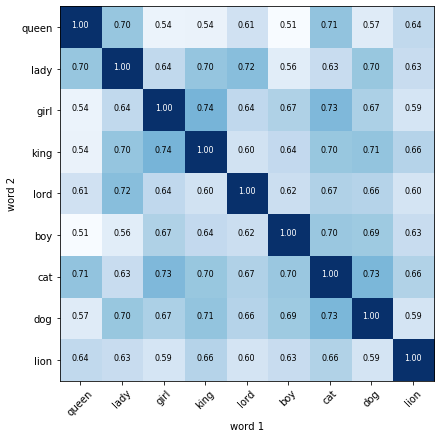

In [19]:
plot_similarity_matrix(similarity, words)